Data Trained over clip-ViT

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from datasets import load_dataset
from transformers import CLIPVisionModel, CLIPProcessor, TrainingArguments, Trainer
from sklearn.metrics import classification_report
from PIL import Image
import evaluate
import shutil
from collections import Counter
from transformers import Trainer

class NoSchedulerTrainer(Trainer):
    def create_scheduler(self, num_training_steps: int, optimizer=None):
        print("Scheduler is disabled.")
        return None

#Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Disk space check
total, used, free = shutil.disk_usage(".")
print(f"Disk space: {free // (2**20)} MB free")
if free < 5 * 2**30:
    raise OSError("Not enough disk space. Please free up space before running this notebook.")

#Load dataset
data_dir = "fabric_dataset2"
dataset = load_dataset("imagefolder", data_dir=data_dir)
split = dataset["train"].train_test_split(test_size=0.2, seed=42)

#Label mapping
labels = split["train"].features["label"].names
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

#CLIP processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

#No augmentation
def apply_augmentation(image):
    #if random.random() < 0.5:
    #    image = ImageOps.mirror(image)
    #if random.random() < 0.3:
    #    image = image.rotate(random.choice([-15, -10, -5, 5, 10, 15]))
    #if random.random() < 0.3:
    #    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    #if random.random() < 0.3:
    #    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    #if random.random() < 0.3:
    #   image = ImageOps.autocontrast(image)
    #if random.random() < 0.3:
    #    image = ImageEnhance.Color(image).enhance(random.uniform(0.8, 1.2))
    return image


#Transform
def transform_fn(example):
    try:
        image = example["image"]
        if not isinstance(image, Image.Image):
            image = Image.fromarray(np.array(image))
        image = image.convert("RGB")
        image = apply_augmentation(image)
        inputs = processor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)
        if pixel_values.shape != (3, 224, 224):
            raise ValueError("Invalid pixel_values shape")
        return {"pixel_values": pixel_values, "label": int(example["label"])}
    except Exception as e:
        print(f"Skipping image due to error: {e}")
        return None

split = split.map(transform_fn, remove_columns=["image"], num_proc=1)
split = split.filter(lambda x: x is not None and "pixel_values" in x and "label" in x)
split["train"] = split["train"].map(lambda x: {"label": int(x["label"])})
split["test"] = split["test"].map(lambda x: {"label": int(x["label"])})

split["train"].set_format(type="torch", columns=["pixel_values", "label"])
split["test"].set_format(type="torch", columns=["pixel_values", "label"])

#Model
class CLIPViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.clip_vit = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.clip_vit.config.hidden_size, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, pixel_values, labels=None):
        outputs = self.clip_vit(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        logits = self.classifier(self.dropout(pooled_output))
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return (loss, logits)

model = CLIPViTClassifier(num_classes=len(labels)).to(device)
#Metrics
accuracy = evaluate.load("accuracy")
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy.compute(predictions=preds, references=p.label_ids)

#Training arguments
args = TrainingArguments(
    output_dir="./clip-vit-fabric",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to=[], 
    max_grad_norm=0.5,
    fp16=True if torch.cuda.is_available() else False,
    remove_unused_columns=False,
    learning_rate=5e-6,
    weight_decay=0.01,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)

#Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=split["train"],
    eval_dataset=split["test"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None), 
)
#Add dropout to the model if not already present
if not hasattr(model, "dropout"):
    model.dropout = nn.Dropout(0.1)

#Train
trainer.train(resume_from_checkpoint=False)

#Evaluate
preds = trainer.predict(split["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=labels))

Disk space: 166376 MB free


Resolving data files:   0%|          | 0/6086 [00:00<?, ?it/s]

c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/3040 [00:00<?, ?it/s]

{'loss': 1.8964, 'grad_norm': 113.29817199707031, 'learning_rate': 4.182565789473684e-06, 'epoch': 0.82}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.200471043586731, 'eval_accuracy': 0.6825657894736842, 'eval_runtime': 39.1721, 'eval_samples_per_second': 31.043, 'eval_steps_per_second': 3.88, 'epoch': 1.0}
{'loss': 0.7782, 'grad_norm': 68.97017669677734, 'learning_rate': 3.360197368421053e-06, 'epoch': 1.64}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.0229848623275757, 'eval_accuracy': 0.7228618421052632, 'eval_runtime': 43.7566, 'eval_samples_per_second': 27.79, 'eval_steps_per_second': 3.474, 'epoch': 2.0}
{'loss': 0.4145, 'grad_norm': 72.41703033447266, 'learning_rate': 2.5378289473684214e-06, 'epoch': 2.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.9954468607902527, 'eval_accuracy': 0.7598684210526315, 'eval_runtime': 38.3628, 'eval_samples_per_second': 31.697, 'eval_steps_per_second': 3.962, 'epoch': 3.0}
{'loss': 0.2153, 'grad_norm': 5.846389293670654, 'learning_rate': 1.7154605263157896e-06, 'epoch': 3.29}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.123142123222351, 'eval_accuracy': 0.7541118421052632, 'eval_runtime': 38.3159, 'eval_samples_per_second': 31.736, 'eval_steps_per_second': 3.967, 'epoch': 4.0}
{'loss': 0.1068, 'grad_norm': 4.598249912261963, 'learning_rate': 8.947368421052632e-07, 'epoch': 4.11}
{'loss': 0.0501, 'grad_norm': 24.68142318725586, 'learning_rate': 7.236842105263158e-08, 'epoch': 4.93}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.1834522485733032, 'eval_accuracy': 0.756578947368421, 'eval_runtime': 44.6113, 'eval_samples_per_second': 27.258, 'eval_steps_per_second': 3.407, 'epoch': 5.0}
{'train_runtime': 2037.4852, 'train_samples_per_second': 11.934, 'train_steps_per_second': 1.492, 'train_loss': 0.5704609810521728, 'epoch': 5.0}


  0%|          | 0/152 [00:00<?, ?it/s]


=== Classification Report ===
                              precision    recall  f1-score   support

   abstract_geometric_fabric       0.58      0.71      0.64        48
               argyle_fabric       0.94      0.91      0.93        34
              checked_fabric       0.82      0.78      0.80        60
              chevron_fabric       0.98      0.85      0.91        54
diagonal_grid_fabric_pattern       0.87      0.72      0.79        57
               floral_fabric       0.69      0.69      0.69        45
               fringe_fabric       0.86      0.60      0.71        30
         glitch_print_fabric       0.66      0.72      0.69        40
              glitter_fabric       0.65      0.56      0.60        39
             gradient_fabric       0.65      0.54      0.59        37
       graffiti_print_fabric       0.73      0.77      0.75        31
          holographic_fabric       0.79      0.74      0.76        35
          houndstooth_fabric       0.74      0.91      0.8

76% accuracy achieved

In [3]:
import torch
import torch.nn as nn
from transformers import CLIPVisionModel

class CLIPViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.clip_vit = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.clip_vit.config.hidden_size, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, pixel_values, labels=None):
        outputs = self.clip_vit(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        logits = self.classifier(self.dropout(pooled_output))
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return (loss, logits)

from safetensors.torch import load_file

model = CLIPViTClassifier(num_classes=29)  # your custom model class
state_dict = load_file("clip-vit-fabric/checkpoint-3040/model.safetensors", device="cpu")
model.load_state_dict(state_dict)
model.eval()




CLIPViTClassifier(
  (clip_vit): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (position_embedding): Embedding(50, 768)
      )
      (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
        

In [12]:
import os

save_dir = "clip-vit-fabric-hf"
os.makedirs(save_dir, exist_ok=True)

# Save model weights
torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))
print("Model weights saved to", os.path.join(save_dir, "pytorch_model.bin"))

# Save CLIP config if you want (from the vision backbone)
model.clip_vit.config.to_json_file(os.path.join(save_dir, "config.json"))
print("Vision Transformer config saved to", os.path.join(save_dir, "config.json"))
from transformers import CLIPProcessor

# Load the original processor from base model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Save it next to your model
processor.save_pretrained("clip-vit-fabric-hf")
print("Processor saved to clip-vit-fabric-hf/")


Model weights saved to clip-vit-fabric-hf\pytorch_model.bin
Vision Transformer config saved to clip-vit-fabric-hf\config.json
Processor saved to clip-vit-fabric-hf/


In [10]:
torch.save(model.state_dict(), "clip_vit_fabric_model.pth")

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix = evaluate.load("confusion_matrix")
confusion_matrix_result = confusion_matrix.compute(predictions=y_pred, references=y_true, labels=list(range(len(labels))))
print("\n=== Confusion Matrix ===")
print(confusion_matrix_result)



=== Confusion Matrix ===
{'confusion_matrix': array([[34,  0,  0,  0,  2,  1,  0,  3,  1,  0,  1,  0,  1,  0,  0,  0,
         0,  0,  1,  0,  1,  0,  0,  0,  0,  2,  1,  0,  0],
       [ 0, 31,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 47,  0,  0,  0,  0,  0,  0,  0,  1,  0,  8,  1,  1,  0,
         0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  0, 46,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  2,  1,  0,  1,  1,  1,  0],
       [ 9,  1,  4,  0, 41,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 31,  0,  0,  0,  0,  1,  0,  0,  0,  3,  4,
         0,  0,  0,  0,  3,  0,  1,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 18,  1,  0,  0,  0,  0,  1,  0,  2,  0,
         1,  0,  1,  1,  0,  1,  1,  1,  0,  2,  0,  0,  0],
       [ 2,  0,  0,  0

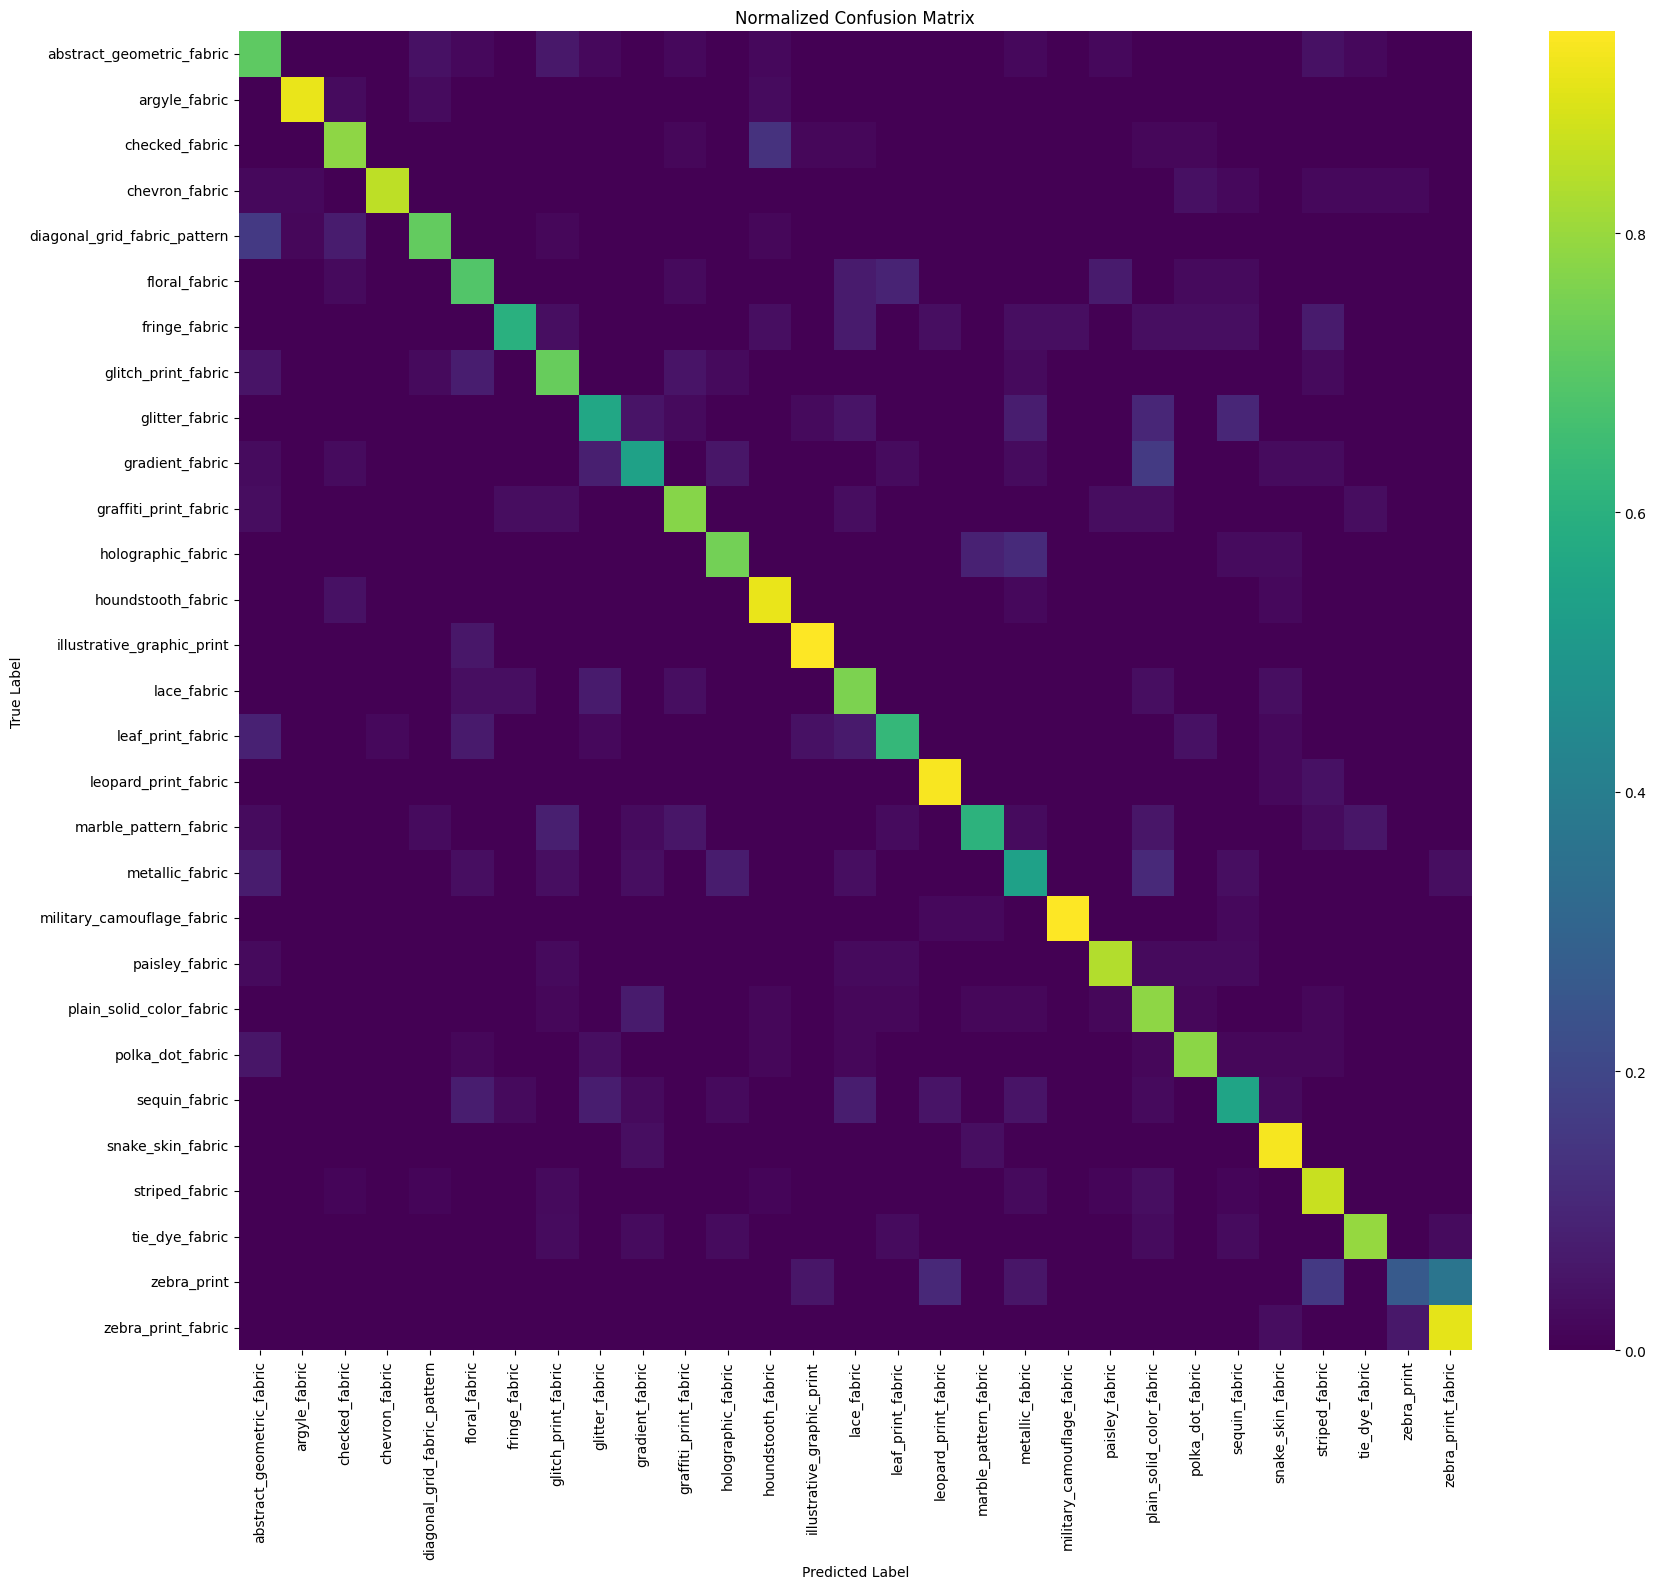

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(18, 16))
sns.heatmap(cm_normalized, annot=False, cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

